In [52]:
import os
import numpy as np
import struct
from numpy import zeros
import array
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy import misc
import time
import sys
# import needed library for MLP 
import torch
import torch.nn as nn
import torch.nn.functional
import torch.utils.data
from torch.autograd import Variable
from itertools import product
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [53]:
def load_mnist(dataset="training", digits=np.arange(10), path=".", size = 60000):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array.array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array.array("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = size #int(len(ind) * size/100.)
    images = zeros((N, rows, cols), dtype='uint8')
    labels = zeros((N, 1), dtype='int8')
    for i in range(N): #int(len(ind) * size/100.)):
        images[i] = np.array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])\
            .reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    labels = [label[0] for label in labels]
    return images, labels

In [54]:
#train and validation data
tr,label = load_mnist("training")
tr_label = np.array(label[0:50000],dtype = np.long)
va_label = np.array(label[50000:60000],dtype = np.long)
train = tr[0:50000]
validate = tr[50000:60000]
#test data
test,te_label = load_mnist("testing")
te_label = np.array(te_label,dtype = np.long)

In [55]:
#normalize data
train = train/256
validate = validate/256
test = test/256

In [56]:
#reshape the array
t_data = np.zeros((50000,784))
v_data = np.zeros((10000,784))
te_data = np.zeros((10000,784))
for i in range(50000):
    t_data[i,:] = train[i].reshape(1,784)
for i in range(10000):
    v_data[i,:] = validate[i].reshape(1,784)
    te_data[i,:] = test[i].reshape(1,784)

In [59]:
# choose component
def PCA_caculate(data,num_components):
    pca = PCA(num_components)
    pca.fit(data)
    x = pca.transform(data)
    return x
train_data = PCA_caculate(t_data,200)
test_data = PCA_caculate(te_data,200)
validate_data = PCA_caculate(v_data,200)
#num_components = 14
#pca = PCA(n_components = num_components)
#pca.fit(train[0])
#x = pca.transform(train[0])
    #pca.fit(test[i])
    #test[i] = pca.transform(test[i])

In [60]:
convert_train = np.zeros((50000,1,200))
convert_test = np.zeros((10000,1,200))
convert_validate = np.zeros((10000,1,200))
for i in range(50000):
    convert_train[i] = train_data[i,:]
for i in range(10000):
    convert_test[i] = test_data[i,:]
    convert_validate = validate_data[i,:]

In [61]:
training=torch.utils.data.DataLoader(torch.from_numpy(convert_train),batch_size = 100)
validation =torch.utils.data.DataLoader(torch.from_numpy(convert_validate),batch_size = 100)
testing =torch.utils.data.DataLoader(torch.from_numpy(convert_test),batch_size = 100)
train_label = torch.from_numpy(tr_label)
validate_label = torch.from_numpy(va_label)
test_label = torch.from_numpy(te_label)

In [62]:
num_drop = 0.5
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.L1 = nn.Linear(200,700)
        self.drop1 = nn.Dropout(num_drop)
        self.L2 = nn.Linear(700,300)
        self.drop2 = nn.Dropout(num_drop)
        self.L3 = nn.Linear(300,10)
    def forward(self,din):
        din = din.view(-1,200)
        dout = torch.nn.functional.relu(self.drop1(self.L1(din)))
        dout = torch.nn.functional.relu(self.drop2(self.L2(dout)))
        return torch.nn.functional.softmax(self.L3(dout))
 #calculate accuracy
def accuracy(preb,label):
    preb = preb.cpu().data.numpy()
    label = label.cpu().data.numpy()
    test_np = (np.argmax(preb,1)==label)
    test_np = np.float32(test_np)
    return (np.mean(test_np))
def MSE(preb,label):
    sumss = 0
    preb = preb.cpu().data.numpy()
    label = label.cpu().data.numpy()
    re = np.argmax(preb,1)
    label = np.float32(label)
    for o in range(100):
        sumss = sumss+(re[o]-label[o])**2
    return (sumss/100)

In [49]:
model = MLP().cuda()
sgd = torch.optim.SGD(model.parameters(),lr = 0.1, momentum = 0.9)
lossfunc = torch.nn.CrossEntropyLoss()
trace = []
MSE=[]
for n in range(20):
    sums=[]
    mse_t=[]
    for i,data in enumerate(training_data):
        sgd.zero_grad()
        data = data.type(torch.FloatTensor)
        labels = train_label[i*100:i*100+100].type(torch.LongTensor)
        inputs = torch.autograd.Variable(data).cuda()
        labels = torch.autograd.Variable(labels).cuda()
        outputs = model(inputs)
        loss = lossfunc(outputs,labels)
        loss.backward()
        sgd.step()
        sums.append(accuracy(outputs,labels))
    trace.append(sum(sums)/len(sums))


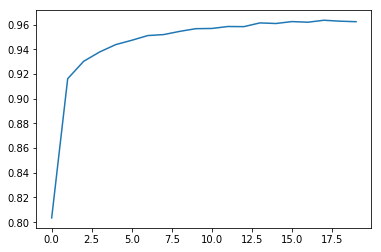

In [50]:
plt.plot(trace)

In [51]:
print(trace[19])

0.962460005283
